In [1]:
library(glue)
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggrepel)
library(forcats)
library(ggthemes)
library(janitor)
library(lubridate)
library(tidyverse)



Attaching package: ‘dplyr’


The following object is masked from ‘package:glue’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  3.0.6     ✔ purrr   0.3.4
✔ readr   1.3.1     ✔ stringr 1.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ dplyr::collapse()        masks glue::collapse()
✖ lubridate::date()        masks base::date()
✖ dpl

the dataset comes from Google BigQuery public datasets, see queries below
this CSv file was created by joining the languages table and the licenses table and then exporting the results
select license, l.name, count(*) as count from (select * from (SELECT
  L.*, R.license
FROM
  `bigquery-public-data.github_repos.languages` L
LEFT JOIN
  `bigquery-public-data.github_repos.licenses` R
ON
  R.repo_name = L.repo_name) ), unnest(language) as l group by license, l.name order by license desc, count desc

In [2]:
licenses_and_languages <- read_csv("github.csv")

Parsed with column specification:
cols(
  license = col_character(),
  name = col_character(),
  count = col_double()
)



In [3]:
head(licenses_and_languages)

license,name,count
<chr>,<chr>,<dbl>
unlicense,JavaScript,9528
unlicense,CSS,6765
unlicense,Shell,6445
unlicense,HTML,6378
unlicense,Python,6239
unlicense,Java,3965


In [7]:
# most commonly used licenses
repos_per_license <- licenses_and_languages %>%
  group_by(license) %>%
  summarize(count = sum(count)) %>%
  arrange(desc(count))

head(repos_per_license)

license,count
<chr>,<dbl>
mit,3596969
apache-2.0,1171094
gpl-2.0,1096600
gpl-3.0,832418
bsd-3-clause,439199
bsd-2-clause,130130


In [12]:
N <- 5
top_n_licenses_and_languages <- licenses_and_languages %>%
  filter(license %in% repos_per_license$license[1:N]) %>%
  group_by(license) %>%
  slice_head(n=N*2) %>%
  ungroup()
head(top_n_licenses_and_languages)
dim(top_n_licenses_and_languages)

license,name,count
<chr>,<chr>,<dbl>
apache-2.0,Java,148662
apache-2.0,JavaScript,131593
apache-2.0,HTML,119628
apache-2.0,CSS,111794
apache-2.0,Shell,110589
apache-2.0,Python,80166


[1] 50  3

In [13]:
data <- top_n_licenses_and_languages %>%
  mutate(id=row_number(), 
         individual = glue("{license} {name}"),
         value = count) %>%
  select(id, individual, value) 
head(data)
data

id,individual,value
<int>,<glue>,<dbl>
1,apache-2.0 Java,148662
2,apache-2.0 JavaScript,131593
3,apache-2.0 HTML,119628
4,apache-2.0 CSS,111794
5,apache-2.0 Shell,110589
6,apache-2.0 Python,80166


id,individual,value
<int>,<glue>,<dbl>
1,apache-2.0 Java,148662
2,apache-2.0 JavaScript,131593
3,apache-2.0 HTML,119628
4,apache-2.0 CSS,111794
5,apache-2.0 Shell,110589
6,apache-2.0 Python,80166
7,apache-2.0 Ruby,41969
8,apache-2.0 Makefile,35243
9,apache-2.0 C,30414


In [40]:
# library
library(tidyverse)
 
# Create dataset
data <- data.frame(
  individual=top_n_licenses_and_languages$name,
  group=top_n_licenses_and_languages$license ,
  value=top_n_licenses_and_languages$count/10000
)
 
# Set a number of 'empty bar' to add at the end of each group
empty_bar <- 3
to_add <- data.frame( matrix(NA, empty_bar*nlevels(data$group), ncol(data)) )
colnames(to_add) <- colnames(data)
to_add$group <- rep(levels(data$group), each=empty_bar)
data <- rbind(data, to_add)
data <- data %>% arrange(group)
data$id <- seq(1, nrow(data))
 
# Get the name and the y position of each label
label_data <- data
number_of_bar <- nrow(label_data)
angle <- 90 - 360 * (label_data$id-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
label_data$hjust <- ifelse( angle < -90, 1, 0)
label_data$angle <- ifelse(angle < -90, angle+180, angle)
 
# prepare a data frame for base lines
base_data <- data %>% 
  group_by(group) %>% 
  summarize(start=min(id), end=max(id) - empty_bar) %>% 
  rowwise() %>% 
  mutate(title=mean(c(start, end)))
 
# prepare a data frame for grid (scales)
grid_data <- base_data
grid_data$end <- grid_data$end[ c( nrow(grid_data), 1:nrow(grid_data)-1)] + 1
grid_data$start <- grid_data$start - 1
grid_data <- grid_data[-1,]


head(data)


# Make the plot
p <- ggplot(data, aes(x=as.factor(id), y=value, fill=group)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  
  geom_bar(aes(x=as.factor(id), y=value, fill=group), stat="identity", alpha=0.5) +
  
  # Add a val=100/75/50/25 lines. I do it at the beginning to make sur barplots are OVER it.
  geom_segment(data=grid_data, aes(x = end, y = 80, xend = start, yend = 80), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 60, xend = start, yend = 60), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 40, xend = start, yend = 40), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 20, xend = start, yend = 20), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  
  # Add text showing the value of each 100/75/50/25 lines
  annotate("text", x = rep(max(data$id),4), y = c(20, 40, 60, 80), label = c("20", "40", "60", "80") , color="grey", size=3 , angle=0, fontface="bold", hjust=1) +
  
  geom_bar(aes(x=as.factor(id), y=value, fill=group), stat="identity", alpha=0.5) +
  ylim(-100,120) +
  #theme_minimal() +
  #theme(
  #  legend.position = "none",
  #  axis.text = element_blank(),
  #  axis.title = element_blank(),
  #  panel.grid = element_blank(),
    #plot.margin = unit(rep(-1,4), "cm") 
  #) +
  coord_polar() + 
  geom_text(data=label_data, aes(x=id, y=value+10, label=individual, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=2.5, angle= label_data$angle, inherit.aes = FALSE ) +
  
  # Add base line information
  geom_segment(data=base_data, aes(x = start, y = -5, xend = end, yend = -5), colour = "black", alpha=0.8, size=0.6 , inherit.aes = FALSE )  +
  geom_text(data=base_data, aes(x = title, y = -18, label=group), hjust=c(1,1,0,0, 1), colour = "black", alpha=0.8, size=4, fontface="bold", inherit.aes = FALSE) +
  scale_fill_tableau() + 
  #theme_fivethirtyeight() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()
        ) +
   labs(title = "Top 10 most commonly used languages in GitHub Repos for Top 5 Licenses",
        subtitle = "Number of repos in tens of thounsands")



,individual,group,value,id
,<fct>,<fct>,<dbl>,<int>
1,Java,apache-2.0,14.8662,1
2,JavaScript,apache-2.0,13.1593,2
3,HTML,apache-2.0,11.9628,3
4,CSS,apache-2.0,11.1794,4
5,Shell,apache-2.0,11.0589,5
6,Python,apache-2.0,8.0166,6


Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


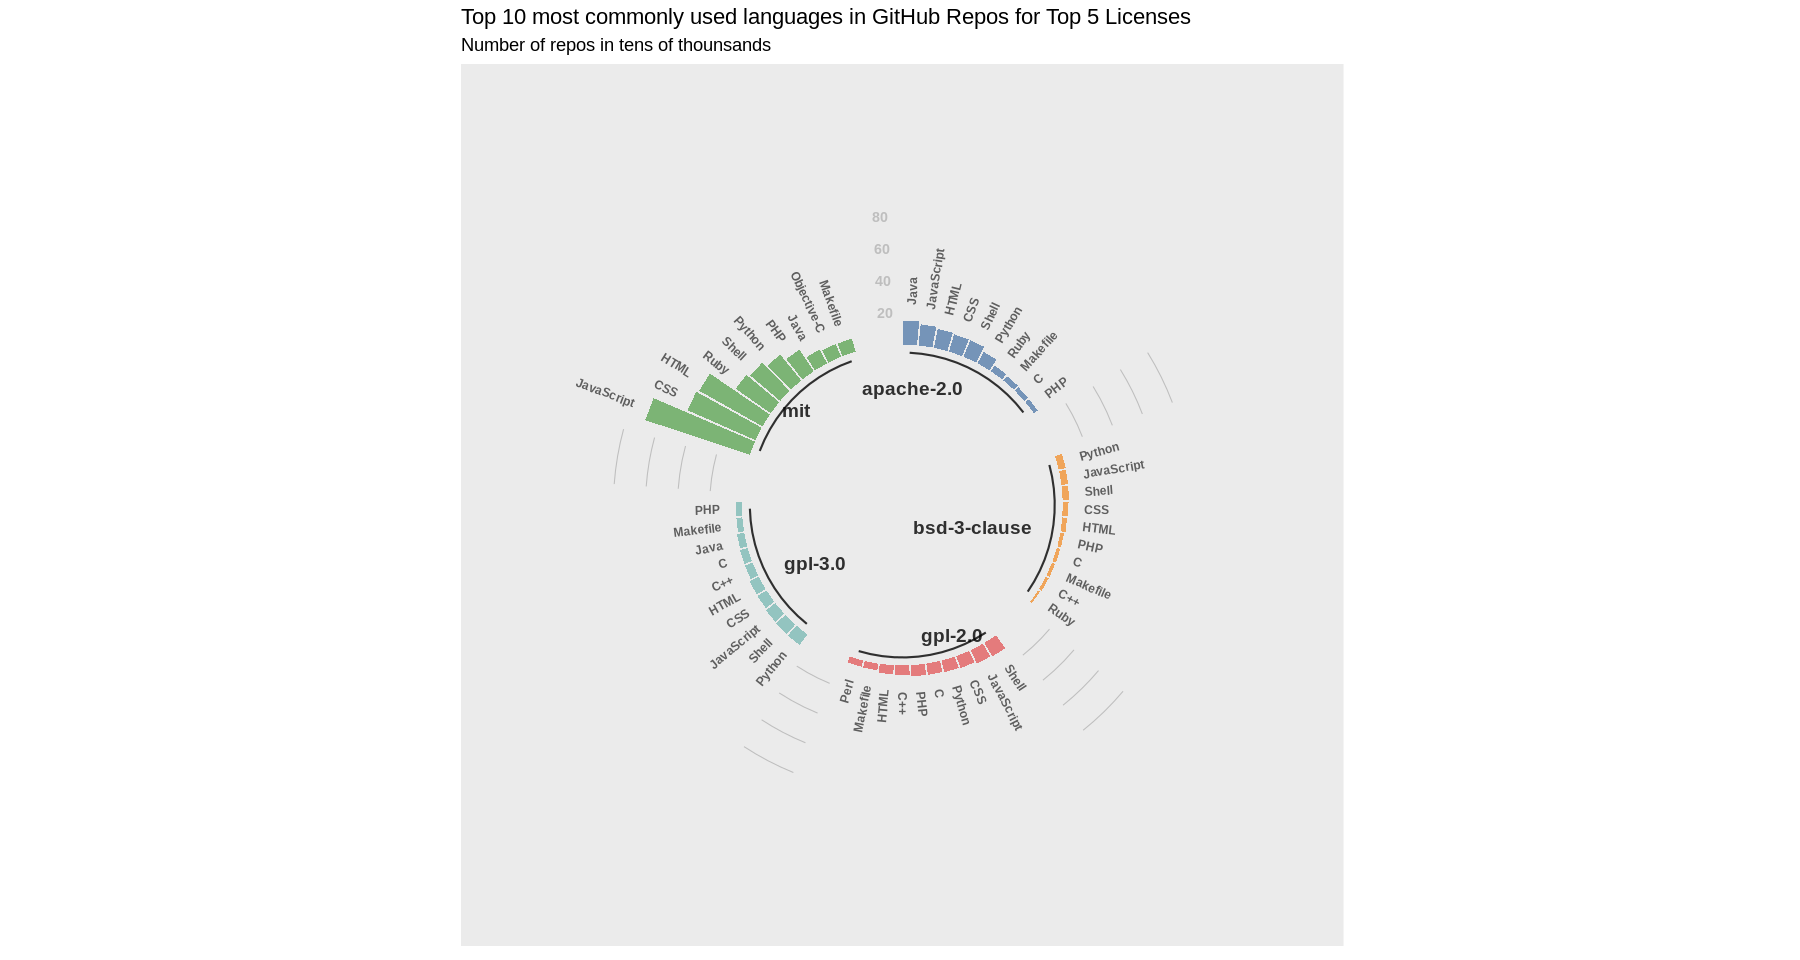

In [41]:
options(repr.plot.width=15, repr.plot.height=8)
p